# Bell–CHSH Test Using Qiskit (Simulator)

## Aim
To implement a Bell–CHSH test on a two-qubit entangled state using **Qiskit AerSimulator** (no IBM API keys needed).

We will:
1. Prepare a maximally entangled two-qubit state.
2. Implement measurement settings (angles) by rotating the measurement basis.
3. Estimate correlations
$$
E(a,b) = \langle AB \rangle
$$
from shot statistics.
4. Compute the CHSH parameter
$$
S = E(a,b) + E(a,b') + E(a',b) - E(a',b')
$$
and observe quantum violation:
$$
|S| \approx 2\sqrt{2}.
$$


## 0. Qiskit Installation Check
If Qiskit is not installed in your environment, install it. Otherwise, skip installation.


In [12]:
!pip install qiskit qiskit-aer

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import qiskit
print(qiskit.__version__)


2.3.0


## 1. Imports and Project Path Setup
Our notebooks are inside `Notebooks/`, so we add the project root to Python’s import path to access `src/`.


In [8]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import numpy as np
from src.models import chsh, chsh_standard_angles


## 2. Measurement Angles in Qiskit (Key Idea)

In a Bell test, Alice and Bob choose measurement axes defined by angles (settings).
In Qiskit, measurements are naturally in the **Z-basis**.

To simulate measuring along an axis at angle $\theta$ (in the X–Z plane), we rotate the qubit **before measuring Z**:

- Apply a rotation $R_y(-\theta)$
- Then measure in Z

This maps the desired measurement axis onto the Z-axis.


## 3. Constructing the Circuit and Estimating Correlations

We prepare a maximally entangled state:
$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle).
$$

Then we apply measurement-basis rotations and estimate:

$$
E(a,b) = \sum_{A,B \in \{+1,-1\}} (AB)\,P(A,B)
$$

by collecting shot counts and mapping bits to eigenvalues:
- bit 0 → +1
- bit 1 → −1


In [9]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

sim = AerSimulator()

def bell_state_circuit():
    """Prepare |Φ+> = (|00> + |11>)/sqrt(2)."""
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    return qc

def measure_along_theta(qc, qubit, theta):
    """
    Measure along an axis in the X–Z plane at angle theta from Z
    by rotating around Y before measuring Z.
    """
    qc.ry(-theta, qubit)

def estimate_E(theta_a, theta_b, shots=20000, seed=123):
    """
    Estimate E(a,b) = <A B> using shot statistics.
    Returns: (E, counts)
    """
    qc = bell_state_circuit()

    # Basis rotations (measurement settings)
    measure_along_theta(qc, 0, theta_a)
    measure_along_theta(qc, 1, theta_b)

    # Measure in Z basis
    qc.measure(0, 0)
    qc.measure(1, 1)

    result = sim.run(qc, shots=shots, seed_simulator=seed).result()
    counts = result.get_counts()

    # Compute correlation from counts
    E = 0.0
    for bitstring, c in counts.items():
        # Qiskit typically returns bitstring as "c1c0"
        b1 = int(bitstring[0])  # qubit 1 result
        b0 = int(bitstring[1])  # qubit 0 result

        A = +1 if b0 == 0 else -1
        B = +1 if b1 == 0 else -1

        E += (A * B) * (c / shots)

    return E, counts


## 4. Sanity Check: One Correlation Value

We compute a single correlation $E(a,b)$ using the standard CHSH angles.


In [10]:
a, ap, b, bp = chsh_standard_angles()

E_ab, counts = estimate_E(a, b, shots=20000, seed=1)
E_ab, counts


(0.6885, {'10': 1531, '11': 8476, '00': 8409, '01': 1584})

## 5. Computing the CHSH Parameter with Qiskit

We estimate the four correlations:
- $E(a,b)$
- $E(a,b')$
- $E(a',b)$
- $E(a',b')$

and compute:

$$
S = E(a,b) + E(a,b') + E(a',b) - E(a',b')
$$


In [11]:
E_ab, _   = estimate_E(a, b,  shots=20000, seed=1)
E_abp, _  = estimate_E(a, bp, shots=20000, seed=2)
E_apb, _  = estimate_E(ap, b, shots=20000, seed=3)
E_apbp, _ = estimate_E(ap, bp,shots=20000, seed=4)

S_qiskit = chsh(E_ab, E_abp, E_apb, E_apbp)

(E_ab, E_abp, E_apb, E_apbp, S_qiskit)


(0.6885, 0.7046, 0.7012, -0.7091, 2.8034)

## 6. Shot Noise: Convergence with Increasing Shots

With finite shots, estimated correlations fluctuate.
Increasing the number of shots reduces statistical noise and stabilizes $S$.


In [12]:
shots_list = [500, 2000, 8000, 20000, 50000]
vals = []

for shots in shots_list:
    E_ab, _   = estimate_E(a, b,  shots=shots, seed=11)
    E_abp, _  = estimate_E(a, bp, shots=shots, seed=12)
    E_apb, _  = estimate_E(ap, b, shots=shots, seed=13)
    E_apbp, _ = estimate_E(ap, bp,shots=shots, seed=14)
    S = chsh(E_ab, E_abp, E_apb, E_apbp)
    vals.append(S)

list(zip(shots_list, vals))


[(500, 2.84),
 (2000, 2.8169999999999997),
 (8000, 2.8407500000000003),
 (20000, 2.851),
 (50000, 2.83952)]

## Interpretation

- The Qiskit simulation uses a maximally entangled two-qubit state and estimates correlations via measurement statistics.
- Measurement "angles" are implemented through basis rotations before Z measurement.
- The computed CHSH value satisfies:
  - local realism: $|S|\le 2$ (not observed here)
  - quantum mechanics: $|S|\le 2\sqrt{2}$ (consistent with our results)
- Remaining deviations from $2\sqrt{2}$ arise from finite-shot statistical noise.


In [13]:
shots_list = [1000, 5000, 20000, 100000]
for shots in shots_list:
    E_ab, _   = estimate_E(a, b,  shots=shots, seed=21)
    E_abp, _  = estimate_E(a, bp, shots=shots, seed=22)
    E_apb, _  = estimate_E(ap, b, shots=shots, seed=23)
    E_apbp, _ = estimate_E(ap, bp,shots=shots, seed=24)
    S = chsh(E_ab, E_abp, E_apb, E_apbp)
    print(f"shots={shots:<6}  S={S:+.5f}  |S|={abs(S):.5f}")


shots=1000    S=+2.76400  |S|=2.76400
shots=5000    S=+2.81600  |S|=2.81600
shots=20000   S=+2.81920  |S|=2.81920
shots=100000  S=+2.82434  |S|=2.82434


In [14]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt

def make_depolarizing_noise(p1=0.0, p2=0.0):
    """
    p1: depolarising probability for 1-qubit gates
    p2: depolarising probability for 2-qubit gates
    """
    noise_model = NoiseModel()
    if p1 > 0:
        noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['ry', 'h'])
    if p2 > 0:
        noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    return noise_model

def estimate_E_noisy(theta_a, theta_b, shots=20000, seed=123, p1=0.0, p2=0.0):
    qc = bell_state_circuit()
    measure_along_theta(qc, 0, theta_a)
    measure_along_theta(qc, 1, theta_b)
    qc.measure(0, 0)
    qc.measure(1, 1)

    noise_model = make_depolarizing_noise(p1=p1, p2=p2)

    result = sim.run(
        qc, shots=shots, seed_simulator=seed,
        noise_model=noise_model
    ).result()

    counts = result.get_counts()
    E = 0.0
    for bitstring, c in counts.items():
        b1 = int(bitstring[0])
        b0 = int(bitstring[1])
        A = +1 if b0 == 0 else -1
        B = +1 if b1 == 0 else -1
        E += (A * B) * (c / shots)
    return E


In [15]:
import numpy as np
p2_values = np.linspace(0, 0.15, 16)   # tune range if needed
S_values = []

for p2 in p2_values:
    E_ab   = estimate_E_noisy(a, b,  shots=30000, seed=31, p1=0.0, p2=float(p2))
    E_abp  = estimate_E_noisy(a, bp, shots=30000, seed=32, p1=0.0, p2=float(p2))
    E_apb  = estimate_E_noisy(ap, b, shots=30000, seed=33, p1=0.0, p2=float(p2))
    E_apbp = estimate_E_noisy(ap, bp,shots=30000, seed=34, p1=0.0, p2=float(p2))
    S = chsh(E_ab, E_abp, E_apb, E_apbp)
    S_values.append(S)

S_values[:5], S_values[-1]


([2.838733333333333,
  2.8087999999999997,
  2.7806,
  2.7516000000000003,
  2.7248666666666663],
 2.423866666666667)

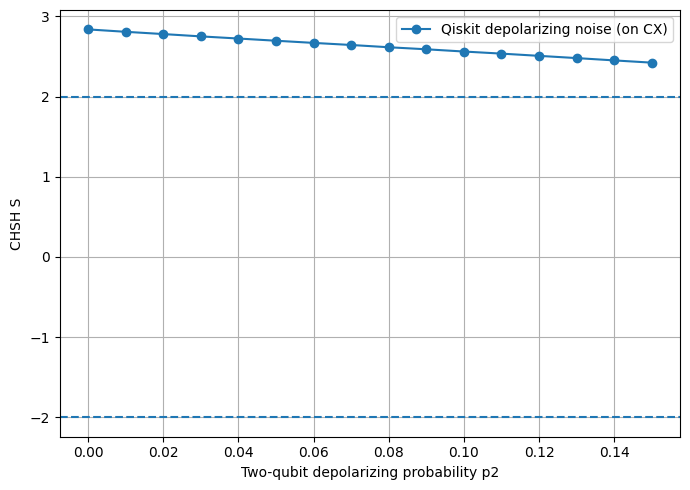

In [16]:
plt.figure(figsize=(7,5))
plt.plot(p2_values, S_values, marker='o', label='Qiskit depolarizing noise (on CX)')
plt.axhline(2.0, linestyle='--')
plt.axhline(-2.0, linestyle='--')
plt.xlabel("Two-qubit depolarizing probability p2")
plt.ylabel("CHSH S")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../figures/S_vs_qiskit_depolarizing.png", dpi=200)
plt.show()


## No-Signalling Check (Marginal Probabilities)

Bell violation does **not** allow faster-than-light communication.

A practical test is to check Bob’s marginal statistics:
- Fix Bob’s measurement setting (e.g. $b$)
- Change Alice’s setting between $a$ and $a'$
- Compare Bob’s probability of getting $B=+1$ (bit 0)

No-signalling predicts:
$$
P(B=+1 \mid b, a) \approx P(B=+1 \mid b, a').
$$


In [17]:
def bob_marginal_Pplus(counts, shots):
    """
    Compute P(B=+1) from counts.
    We defined B=+1 <-> Bob bit = 0.
    Qiskit bitstring is typically "c1c0" where c1 is qubit1(Bob), c0 is qubit0(Alice).
    """
    p = 0.0
    for bitstring, c in counts.items():
        b1 = int(bitstring[0])  # Bob bit
        if b1 == 0:
            p += c / shots
    return p


In [18]:
shots = 50000  # large for clean marginals

# Fix Bob setting to b, vary Alice setting a vs a'
E1, counts_ab = estimate_E(a, b, shots=shots, seed=101)
E2, counts_apb = estimate_E(ap, b, shots=shots, seed=102)

P_Bplus_ab  = bob_marginal_Pplus(counts_ab, shots)
P_Bplus_apb = bob_marginal_Pplus(counts_apb, shots)

print("Bob marginal with Bob setting b:")
print(f"P(B=+1 | a, b)   = {P_Bplus_ab:.5f}")
print(f"P(B=+1 | a', b)  = {P_Bplus_apb:.5f}")
print(f"Difference       = {abs(P_Bplus_ab - P_Bplus_apb):.5f}")


Bob marginal with Bob setting b:
P(B=+1 | a, b)   = 0.50098
P(B=+1 | a', b)  = 0.50260
Difference       = 0.00162


In [19]:
E3, counts_abp  = estimate_E(a, bp, shots=shots, seed=103)
E4, counts_apbp = estimate_E(ap, bp, shots=shots, seed=104)

P_Bplus_abp  = bob_marginal_Pplus(counts_abp, shots)
P_Bplus_apbp = bob_marginal_Pplus(counts_apbp, shots)

print("Bob marginal with Bob setting b':")
print(f"P(B=+1 | a, b')   = {P_Bplus_abp:.5f}")
print(f"P(B=+1 | a', b')  = {P_Bplus_apbp:.5f}")
print(f"Difference        = {abs(P_Bplus_abp - P_Bplus_apbp):.5f}")


Bob marginal with Bob setting b':
P(B=+1 | a, b')   = 0.49884
P(B=+1 | a', b')  = 0.50262
Difference        = 0.00378


### Interpretation (No-Signalling)

Although the joint correlations violate the Bell–CHSH inequality, Bob’s local outcome distribution
remains (approximately) unchanged when Alice changes her measurement setting.

Small differences arise from finite-shot statistical fluctuations.

This confirms that Bell nonlocality does **not** imply faster-than-light signalling: entanglement
creates stronger-than-classical correlations, but does not allow controllable communication.


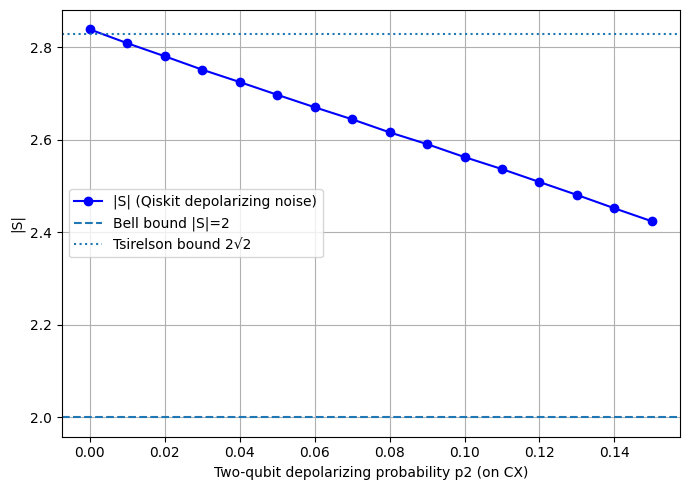

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,5))
plt.plot(p2_values, np.abs(S_values), marker='o',color='blue', label='|S| (Qiskit depolarizing noise)')

plt.axhline(2.0, linestyle='--', label='Bell bound |S|=2')
plt.axhline(2*np.sqrt(2), linestyle=':', label='Tsirelson bound 2√2')

plt.xlabel("Two-qubit depolarizing probability p2 (on CX)")
plt.ylabel("|S|")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../figures/absS_vs_qiskit_depolarizing.png", dpi=200)
plt.show()


In [24]:
for shots in [5000, 20000, 50000, 100000, 2000000]:
    _,counts_ab = estimate_E(a,b, shots =shots, seed = 201)
    _,counts_apb = estimate_E(ap,b, shots = shots, seed = 202)

    p1 = bob_marginal_Pplus(counts_ab, shots)
    p2 = bob_marginal_Pplus(counts_apb, shots)

    diff = abs(p1-p2)
    print(f"Shots = {shots:<7} diff={diff:.6f}")

Shots = 5000    diff=0.001400
Shots = 20000   diff=0.001100
Shots = 50000   diff=0.005820
Shots = 100000  diff=0.003700
Shots = 2000000 diff=0.000004


### No-Signaliing conclusion
The difference in Bob's marginal probability when Alice changes her measurement setting is  $\Delta \approx 3.8\times 10^{-3}$, which is consistent with finite-shot statistical fluctuations.
As the number of shots increases, $\Delta$ decreases, supporting the non-signaling prediction:
Alice's measurement choice cannot be used to control Bob's local statistics.
Thus, Bell-CHSH violation reflects non-classical correlation (failure of local realism), not faster-than-light communication.